# Basic federated classifier with TensorFlow

The code in this notebook is copyright 2018 <a href='https://comind.org/'>coMind</a>. Licensed under the Apache License, Version 2.0; you may not use this code except in compliance with the License. You may obtain a copy of the <a href='http://www.apache.org/licenses/LICENSE-2.0'>License</a>.

Join the <a href='https://comindorg.slack.com/join/shared_invite/enQtNDMxMzc0NDA5OTEwLWIyZTg5MTg1MTM4NjhiNDM4YTU1OTI1NTgwY2NkNzZjYWY1NmI0ZjIyNWJiMTNkZmRhZDg2Nzc3YTYyNGQzM2I'>conversation</a> at Slack.

This a series of three tutorials you are in the last one: 
* [Basic Classifier](https://github.com/coMindOrg/federated-averaging-tutorials/blob/master/Basic%20Classifier.ipynb)
* [Basic Distributed Classifier](https://github.com/coMindOrg/federated-averaging-tutorials/blob/master/Basic%20Distributed%20Classifier.ipynb)
* [Basic Federated Classifier](https://github.com/coMindOrg/federated-averaging-tutorials/blob/master/Basic%20Federated%20Classifier.ipynb)

In this tutorial we will see how to train a model using federated averaging.

To begin a brief explanation of what it means to train using federated averaging with respect to training using a SyncReplicasOptimizer.

In the previous tutorial, we explained that with SyncReplicasOptimizer each worker generated a gradient for its weights and wrote it to the parameter server. The chief read those gradients (including its own), it averaged them and updated the shared model.

This time each worker will be updating its weights locally, as if it were the only one training. Every certain number of steps it will send its weights (not the gradients, but the weights themselves) to the parameter server. The chief will read the weights from there, it will average and write them again to the parameter server so that all the workers can overwrite theirs.

The entire first part of the code is the same as the distributed classifier tutorial.

Two differences only:

- This time we also import __federated_average_optimizer__, the library with which we can federalize learning.
- On the other hand we define the variable __INTERVAL_STEPS__. Every how many steps we will perform the average of the weights. Put another way, how many steps will each worker make in local before writing their weights in the parameter server and overwriting them with the average that the chief has made.

In [1]:
# TensorFlow and tf.keras
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.disable_eager_execution()
from tensorflow import keras

# Helper libraries
import os
import numpy as np
from time import time
import matplotlib.pyplot as plt
import federated_averaging_optimizer

flags = tf.app.flags
flags.DEFINE_integer("task_index", None,
                     "Worker task index, should be >= 0. task_index=0 is "
                     "the master worker task that performs the variable "
                     "initialization ")
flags.DEFINE_string("ps_hosts", "localhost:2222",
                    "Comma-separated list of hostname:port pairs")
flags.DEFINE_string("worker_hosts", "localhost:2223,localhost:2224",
                    "Comma-separated list of hostname:port pairs")
flags.DEFINE_string("job_name", None, "job name: worker or ps")
flags.DEFINE_string('f', '', 'kernel')


BATCH_SIZE = 32
EPOCHS = 30
INTERVAL_STEPS = 3

FLAGS = flags.FLAGS
FLAGS.job_name = "worker"
FLAGS.task_index = 0

if FLAGS.job_name is None or FLAGS.job_name == "":
    raise ValueError("Must specify an explicit `job_name`")
if FLAGS.task_index is None or FLAGS.task_index == "":
    raise ValueError("Must specify an explicit `task_index`")

if FLAGS.task_index == 0:
    print('--- GPU Disabled ---')
    os.environ['CUDA_VISIBLE_DEVICES'] = ''

#Construct the cluster and start the server
ps_spec = FLAGS.ps_hosts.split(",")
worker_spec = FLAGS.worker_hosts.split(",")

# Get the number of workers.
num_workers = len(worker_spec)
print('{} workers defined'.format(num_workers))

cluster = tf.train.ClusterSpec({"ps": ps_spec, "worker": worker_spec})

server = tf.train.Server(cluster, job_name=FLAGS.job_name, task_index=FLAGS.task_index)
if FLAGS.job_name == "ps":
    print('--- Parameter Server Ready ---')
    server.join()

fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
print('Data loaded')

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

train_images = np.split(train_images, num_workers)[FLAGS.task_index]
train_labels = np.split(train_labels, num_workers)[FLAGS.task_index]
print('Local dataset size: {}'.format(train_images.shape[0]))

train_images = train_images / 255.0
test_images = test_images / 255.0

is_chief = (FLAGS.task_index == 0)

checkpoint_dir='logs_dir/federated_worker_{}/{}'.format(FLAGS.task_index, time())
print('Checkpoint directory: ' + checkpoint_dir)

worker_device = "/job:worker/task:%d" % FLAGS.task_index
print('Worker device: ' + worker_device + ' - is_chief: {}'.format(is_chief))

Instructions for updating:
non-resource variables are not supported in the long term
--- GPU Disabled ---
2 workers defined
Data loaded
Local dataset size: 30000
Checkpoint directory: logs_dir/federated_worker_0/1582488309.0046647
Worker device: /job:worker/task:0 - is_chief: True


Here we begin the definition of the graph in the same way as it was done in the basic classifier, we explicitly place every operation in the local worker. The rest is fairly standard until we reach the definition of the optimizer.

In [3]:
with tf.device(worker_device):
    global_step = tf.train.get_or_create_global_step()

    with tf.name_scope('dataset'), tf.device('/cpu:0'):
        images_placeholder = tf.placeholder(train_images.dtype, [None, train_images.shape[1], train_images.shape[2]], 
                                            name='images_placeholder')
        labels_placeholder = tf.placeholder(train_labels.dtype, [None], name='labels_placeholder')
        batch_size = tf.placeholder(tf.int64, name='batch_size')
        shuffle_size = tf.placeholder(tf.int64, name='shuffle_size')

        dataset = tf.data.Dataset.from_tensor_slices((images_placeholder, labels_placeholder))
        dataset = dataset.shuffle(shuffle_size, reshuffle_each_iteration=True)
        dataset = dataset.repeat(EPOCHS)
        dataset = dataset.batch(batch_size)
        iterator = tf.data.Iterator.from_structure(dataset.output_types, dataset.output_shapes)
        dataset_init_op = iterator.make_initializer(dataset, name='dataset_init')
        X, y = iterator.get_next()

    flatten_layer = tf.layers.flatten(X, name='flatten')

    dense_layer = tf.layers.dense(flatten_layer, 128, activation=tf.nn.relu, name='relu')

    predictions = tf.layers.dense(dense_layer, 10, activation=tf.nn.softmax, name='softmax')

    summary_averages = tf.train.ExponentialMovingAverage(0.9)

    with tf.name_scope('loss'):
        loss = tf.reduce_mean(keras.losses.sparse_categorical_crossentropy(y, predictions))
        loss_averages_op = summary_averages.apply([loss])
        tf.summary.scalar('cross_entropy', summary_averages.average(loss))

    with tf.name_scope('accuracy'):
        with tf.name_scope('correct_prediction'):
            correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.cast(y, tf.int64))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy_metric')
        accuracy_averages_op = summary_averages.apply([accuracy])
        tf.summary.scalar('accuracy', summary_averages.average(accuracy))


Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_classes(iterator)`.
Instructions for updating:
Use keras.layers.Flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.Dense instead.


We used the __replica_device_setter__ in the distributed learning to automatically choose in which device to place each defined op. Here we create it just to pass it as an argument to the custom optimizer that we have created to contain the logic of the federated averaging.

This custom optimizer will use the __replica_device_setter__ to place a copy of each trainable variable in the ps, this new variables will store the averaged values of all the local models.

Once this optimizer has been defined, we create the training operation and a, in the same way as we did with SyncReplicasOptimizer, a hook that will run inside the MonitoredTrainingSession, which handles the initialization.

In [4]:
    with tf.name_scope('train'):
        device_setter = tf.train.replica_device_setter(worker_device=worker_device, cluster=cluster)
        optimizer = federated_averaging_optimizer.FederatedAveragingOptimizer(
            tf.train.AdamOptimizer(np.sqrt(num_workers) * 0.001), 
            replicas_to_aggregate=num_workers, interval_steps=INTERVAL_STEPS, is_chief=is_chief, 
            device_setter=device_setter)
        with tf.control_dependencies([loss_averages_op, accuracy_averages_op]):
            train_op = optimizer.minimize(loss, global_step=global_step)
        model_average_hook = optimizer.make_session_run_hook()

INFO:tensorflow:FedAvgV4: replicas_to_aggregate=2; total_num_replicas=2
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


We keep defining our hooks as usual.

In [5]:
n_batches = int(train_images.shape[0] / BATCH_SIZE)
last_step = int(n_batches * EPOCHS)

print('Graph definition finished')

sess_config = tf.ConfigProto(
    allow_soft_placement=True,
    log_device_placement=False,
    operation_timeout_in_ms=20000,
    device_filters=["/job:ps",
    "/job:worker/task:%d" % FLAGS.task_index])

print('Training {} batches...'.format(last_step))

class _LoggerHook(tf.train.SessionRunHook):
    def begin(self):
        self._total_loss = 0
        self._total_acc = 0

    def before_run(self, run_context):
        return tf.train.SessionRunArgs([loss, accuracy, global_step])

    def after_run(self, run_context, run_values):
        loss_value, acc_value, step_value = run_values.results
        self._total_loss += loss_value
        self._total_acc += acc_value
        if (step_value + 1) % n_batches == 0 and not step_value == 0:
            print("Epoch {}/{} - loss: {:.4f} - acc: {:.4f}".format(
                int(step_value / n_batches) + 1, EPOCHS, self._total_loss / n_batches, self._total_acc / n_batches))
            self._total_loss = 0
            self._total_acc = 0

class _InitHook(tf.train.SessionRunHook):
    def after_create_session(self, session, coord):
        session.run(dataset_init_op, feed_dict={
            images_placeholder: train_images, labels_placeholder: train_labels, 
            batch_size: BATCH_SIZE, shuffle_size: train_images.shape[0]})

Graph definition finished
Training 28110 batches...


The shared variables generated within the custom optimizer get their initialized value from their corresponding trainable variables in the local worker. Therefore their initialization ops will be unavailable out of this session even if we try to restore a saved checkpoint.

We need to define a custom saver which ignores this shared variables. In this case, we only save the trainable_variables .

In [8]:
class _SaverHook(tf.train.SessionRunHook):
    def begin(self):
        self._saver = tf.train.Saver(tf.trainable_variables())

    def before_run(self, run_context):
        return tf.train.SessionRunArgs(global_step)

    def after_run(self, run_context, run_values):
        step_value = run_values.results
        if step_value % n_batches == 0 and not step_value == 0:
            self._saver.save(run_context.session, checkpoint_dir+'/model.ckpt', step_value)

    def end(self, session):
        self._saver.save(session, checkpoint_dir+'/model.ckpt', session.run(global_step))

The execution of the training session is standard. Notice the new hooks that we have added to the hook lists.

WARNING! Do not define a chief worker. We need each worker to initialize their local session and train on its own!

In [10]:
with tf.name_scope('monitored_session'):
    with tf.train.MonitoredTrainingSession(
            master=server.target,
            checkpoint_dir=checkpoint_dir,
            hooks=[_LoggerHook(), _InitHook(), _SaverHook(), model_average_hook],
            config=sess_config,
            stop_grace_period_secs=10,
            save_checkpoint_secs=None) as mon_sess:
        while not mon_sess.should_stop():
            mon_sess.run(train_op)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:global_step/sec: 101.219
INFO:tensorflow:global_step/sec: 103.851
INFO:tensorflow:global_step/sec: 118.925
INFO:tensorflow:global_step/sec: 135.277
INFO:tensorflow:global_step/sec: 115.337
INFO:tensorflow:global_step/sec: 107.484
INFO:tensorflow:global_step/sec: 101.449
INFO:tensorflow:global_step/sec: 111.666
INFO:tensorflow:global_step/sec: 120.032
Epoch 1/30 - loss: 0.6209 - acc: 0.7856
INFO:tensorflow:global_step/sec: 76.6621
INFO:tensorflow:global_step/sec: 100.726
INFO:tensorflow:global_step/sec: 108.235
INFO:tensorflow:global_step/sec: 134.992
INFO:tensorflow:global_step/sec: 135.288
INFO:tensorflow:global_step/sec: 139.838
INFO:tensorflow:global_step/sec: 139.55
INFO:tensorflow:global_step/sec: 138.198
INFO:tensorflow:global_step/sec: 138.352
Epoch 2/30 - loss: 0.4454 - acc: 0.8419
INFO:tensorflow:global_step/sec: 103.44
INFO:tensorflow:global_

INFO:tensorflow:global_step/sec: 108.171
INFO:tensorflow:global_step/sec: 139.376
INFO:tensorflow:global_step/sec: 142.482
INFO:tensorflow:global_step/sec: 144.026
INFO:tensorflow:global_step/sec: 145.048
INFO:tensorflow:global_step/sec: 142.753
INFO:tensorflow:global_step/sec: 143.447
INFO:tensorflow:global_step/sec: 144.92
INFO:tensorflow:global_step/sec: 141.318
Epoch 16/30 - loss: 0.2405 - acc: 0.9101
INFO:tensorflow:global_step/sec: 109.672
INFO:tensorflow:global_step/sec: 142.061
INFO:tensorflow:global_step/sec: 143.228
INFO:tensorflow:global_step/sec: 143.8
INFO:tensorflow:global_step/sec: 144.408
INFO:tensorflow:global_step/sec: 143.687
INFO:tensorflow:global_step/sec: 142.505
INFO:tensorflow:global_step/sec: 143.835
INFO:tensorflow:global_step/sec: 143.43
INFO:tensorflow:global_step/sec: 141.325
Epoch 17/30 - loss: 0.2345 - acc: 0.9129
INFO:tensorflow:global_step/sec: 110.359
INFO:tensorflow:global_step/sec: 144.417
INFO:tensorflow:global_step/sec: 144.048
INFO:tensorflow:glob

DeadlineExceededError: Operation timed out.

Finally, we evaluate the model.

--- Begin Evaluation ---
INFO:tensorflow:Restoring parameters from logs_dir/federated_worker_0/1582488309.0046647/model.ckpt-28110
Model restored
Test accuracy: 0.884900


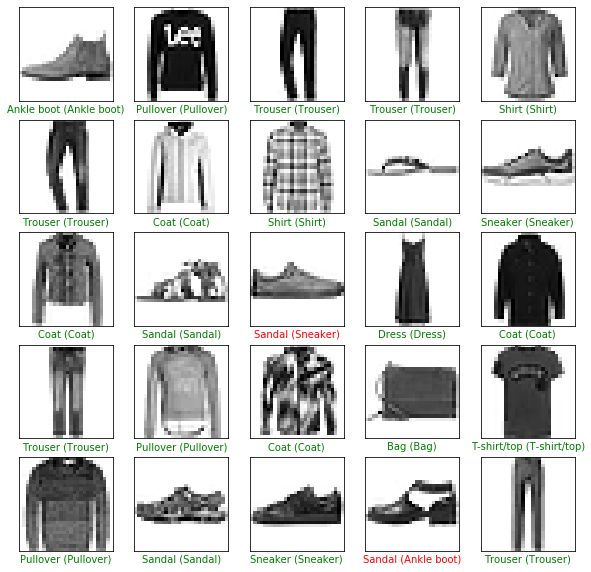

In [12]:

if is_chief:
    print('--- Begin Evaluation ---')
    # Reset graph and load it again to clean tensors placed in other devices
    tf.reset_default_graph()
    with tf.Session() as sess:
        ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
        saver = tf.train.import_meta_graph(ckpt.model_checkpoint_path + '.meta', clear_devices=True)
        saver.restore(sess, ckpt.model_checkpoint_path)
        print('Model restored')
        graph = tf.get_default_graph()
        images_placeholder = graph.get_tensor_by_name('dataset/images_placeholder:0')
        labels_placeholder = graph.get_tensor_by_name('dataset/labels_placeholder:0')
        batch_size = graph.get_tensor_by_name('dataset/batch_size:0')
        shuffle_size = graph.get_tensor_by_name('dataset/shuffle_size:0')
        accuracy = graph.get_tensor_by_name('accuracy/accuracy_metric:0')
        predictions = graph.get_tensor_by_name('softmax/BiasAdd:0')
        dataset_init_op = graph.get_operation_by_name('dataset/dataset_init')
        sess.run(dataset_init_op, feed_dict={images_placeholder: test_images, labels_placeholder: test_labels, batch_size: test_images.shape[0], shuffle_size: 1})
        print('Test accuracy: {:4f}'.format(sess.run(accuracy)))
        predicted = sess.run(predictions)

    # Plot the first 25 test images, their predicted label, and the true label
    # Color correct predictions in green, incorrect predictions in red
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(test_images[i], cmap=plt.cm.binary)
        predicted_label = np.argmax(predicted[i])
        true_label = test_labels[i]
        if predicted_label == true_label:
          color = 'green'
        else:
          color = 'red'
        plt.xlabel("{} ({})".format(class_names[predicted_label],
                                    class_names[true_label]),
                                    color=color)

    plt.show(True)
